In [108]:
!nvidia-smi

Wed Aug  3 01:30:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:3B:00.0 Off |                  N/A |
| 41%   41C    P8    28W / 280W |   2377MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:86:00.0 Off |                  N/A |
| 40%   

In [2]:
# config
import torch
import torch.nn as nn

# hyperparameters
gpu_id = 0 if torch.cuda.is_available() else -1
device = torch.device('cuda:1')
max_seq_len = 100
train_ratio = .8
valid_ratio = .1
hidden_size = 512
output_size = 1
num_head = 8
num_encoder = 12
use_leakyrelu = True
dropout_p = .1
learning_rate = 0.001
grad_acc = True
grad_acc_iter = 8

batch_size = 64
n_epochs = 2

In [3]:
# dataloader
from dataloaders.assist2009_pid_diff_loader import ASSIST2009_PID_DIFF
from utils import pid_diff_collate_fn
from torch.utils.data import DataLoader, random_split

dataset = ASSIST2009_PID_DIFF(max_seq_len)
num_q = dataset.num_q
num_r = dataset.num_r
num_pid = dataset.num_pid
num_diff = dataset.num_diff
collate = pid_diff_collate_fn

train_size = int( len(dataset) * train_ratio * (1 - valid_ratio))
valid_size = int( len(dataset) * train_ratio * valid_ratio)
test_size = len(dataset) - (train_size + valid_size)

train_dataset, valid_dataset, test_dataset = random_split(
    dataset, [ train_size, valid_size, test_size ]
    )

train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True, # train_loader use shuffle
    collate_fn = collate
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size = batch_size,
    shuffle = False, # valid_loader don't use shuffle
    collate_fn = collate
)
test_loader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False, # test_loader don't use shuffle
    collate_fn = collate
)

In [4]:
from models.visualizer_monacobert import MonaConvBert4ktPlusDiff
from models.visualizer_monabert import MonaBert4ktPlusDiff
from models.visualizer_convbert import ConvBert4ktPlusDiff
from models.visualizer_bert import Bert4ktPlusDiff

model_monaco = MonaConvBert4ktPlusDiff(
    num_q=num_q,
    num_r=num_r,
    num_pid=num_pid,
    num_diff=num_diff,
    hidden_size=hidden_size,
    output_size=output_size,
    num_head=16, # TODO : 16 인데 실제로는 8 임, head_ratio 확인
    num_encoder=num_encoder,
    max_seq_len=max_seq_len,
    device=device,
    use_leakyrelu=use_leakyrelu,
    dropout_p=dropout_p
).to(device)

model_monaco_path = '/root/BiDKT/model_records/assist09.pth'

model_list = [model_monaco]
model_path_list = [model_monaco_path]

for model, model_path in zip(model_list, model_path_list):
    model_dict = torch.load(model_path, map_location = device)
    model.load_state_dict(model_dict['model'])

In [5]:
from torch.optim import Adam
from torch.nn.functional import binary_cross_entropy

optimizer = Adam(model.parameters(), learning_rate)
crit = binary_cross_entropy

In [87]:
import torch
from copy import deepcopy

from torch.nn.functional import one_hot
from sklearn import metrics
import numpy as np
from tqdm import tqdm
from random import random, randint

from utils import EarlyStopping

# For Train MLM
# 15% <MASK>, 80% of 15% are real <MASK>, 10% of 15% are reverse, 10% of 15% are not changed
def Mlm4BertTrain(r_seqs, mask_seqs):
    #|r_seqs| = (bs, n)

    mlm_r_seqs = []
    mlm_idxs = []

    # <PAD> is -1
    for r_seq, mask_seq in zip(r_seqs, mask_seqs):
        r_len = r_seq.size(0)
        # real_r_seq: r_seq with no <PAD>
        real_r_seq = torch.masked_select(r_seq, mask_seq).cpu()
        real_r_seq_len = real_r_seq.size(0)

        mlm_idx = np.random.choice(real_r_seq_len, int(real_r_seq_len*0.15), replace=False)

        for idx in mlm_idx:
            if random() < 0.8: # 15% of 80% are <MASK>
                real_r_seq[idx] = 2 # <MASK> is 2
            elif random() < 0.5: # 15% of 10% are random among the 0 or 1
                real_r_seq[idx] = randint(0, 1)
            # 15% of 10% are same with original

        # cover the PAD(-1)
        pad_len = r_len - real_r_seq_len
        # <PAD> is 3
        pad_seq = torch.full((1, pad_len), 3).squeeze(0) 
        # combine the <PAD>
        pad_r_seq = torch.cat((real_r_seq, pad_seq), dim=-1)
        # append to the mlm_r_seqs
        mlm_r_seqs.append(pad_r_seq)

        # <MASK> idx bool
        # make zero vector with r_len size
        mlm_zeros = np.zeros(shape=(r_len, ))
        # mlm_idx are 1
        mlm_zeros[mlm_idx] = 1
        # append to the mlm_idxs
        mlm_idxs.append(mlm_zeros)

    mlm_r_seqs = torch.stack(mlm_r_seqs)
    mlm_idxs = torch.BoolTensor(mlm_idxs)

    # mlm_r_seqs: masked r_seqs
    # mlm_idx: masked idx
    return mlm_r_seqs, mlm_idxs
    # |mlm_r_seqs| = (bs, n)
    # |mask_seqs| = (bs, n)

# For Test MLM
# The last of seq will be changed to the <MASK>
def Mlm4BertTest(r_seqs, mask_seqs):
    #|r_seqs| = (bs, n)

    mlm_r_seqs = []
    mlm_idxs = []

    for r_seq, mask_seq in zip(r_seqs, mask_seqs):
        r_len = r_seq.size(0)

        real_r_seq = torch.masked_select(r_seq, mask_seq).cpu()
        real_r_seq_len = real_r_seq.size(0)

        # last index of real_r_seq
        mlm_idx = real_r_seq_len - 1
        # last index get a <MASK>, <MASK> is 2
        real_r_seq[mlm_idx] = 2

        pad_len = r_len - real_r_seq_len
        pad_seq = torch.full((1, pad_len), 3).squeeze(0) # <PAD> is 3
        pad_r_seq = torch.cat((real_r_seq, pad_seq), dim=-1)
        mlm_r_seqs.append(pad_r_seq)

        mlm_zeros = np.zeros(shape=(r_len, ))
        mlm_zeros[mlm_idx] = 1
        mlm_idxs.append(mlm_zeros)

    mlm_r_seqs = torch.stack(mlm_r_seqs)
    mlm_idxs = torch.BoolTensor(mlm_idxs)

    return mlm_r_seqs, mlm_idxs
    # |mlm_r_seqs| = (bs, n)
    # |mask_seqs| = (bs, n)

class Tester():
    def __init__(
        self, 
        model, 
        optimizer, 
        n_epochs, 
        device, 
        num_q, 
        crit, 
        max_seq_len, 
        response=2,
        use_mlm_r_seqs=True,
        grad_acc=False, 
        grad_acc_iter=4
        ):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.n_epochs = n_epochs
        self.device = device
        self.num_q = num_q
        self.crit = crit
        self.max_seq_len = max_seq_len
        self.grad_acc = grad_acc #gradient accumulation
        self.grad_acc_iter = grad_acc_iter
        
        self.response = response
        self.use_mlm_r_seqs = use_mlm_r_seqs
        
        # save the vis
        self.attn_dict = {head_idx : {layer_idx : [] for layer_idx in range(num_encoder)} for head_idx in range(model.encoder[0].attn.num_attention_heads)}

        self.filter_dict_q    = {q_idx : {layer_idx : [] for layer_idx in range(num_encoder)} for q_idx in range(model.num_q)}
        self.filter_dict_pid  = {emb_idx : {layer_idx : [] for layer_idx in range(num_encoder)} for emb_idx in range(model.num_pid)}
        self.filter_dict_diff = {diff_idx : {layer_idx : [] for layer_idx in range(num_encoder)} for diff_idx in range(model.num_diff)}

        self.conv_value_dict_q    = {q_idx : {layer_idx : [] for layer_idx in range(num_encoder)} for q_idx in range(model.num_q)}
        self.conv_value_dict_pid  = {emb_idx : {layer_idx : [] for layer_idx in range(num_encoder)} for emb_idx in range(model.num_pid)}
        self.conv_value_dict_diff = {diff_idx : {layer_idx : [] for layer_idx in range(num_encoder)} for diff_idx in range(model.num_diff)}
        
    def _save_blackbox(self, data, mlm_r_seqs = None):
        '''save attn, filter, conv_value to self.~
        '''
        
        def _hook_blackbox(attn):
            '''get attn, filter, conv_value from self.model.encoder.attn
            attn_scores : [bs, head_idx, num_seq, num_seq]
            conv_values : [bs, num_seq, head_idx, hidden_dim]
            conv_filter : [bs, num_seq, head_idx, kernel_size]
            '''
            attn_scores = attn.attn_scores 
            conv_values = rearrange(
                attn.conv_value_vectors.detach().clone(), 
                'bs (h_idx h_size) n 1 -> bs n h_idx h_size', h_idx = 8)
            conv_filter = rearrange(
                attn.filters.detach().clone(), 
                '(bs n h) k 1 -> bs n h k', n = 100, h = 8)
            return {'attn' : attn_scores, 'value' : conv_values, 'filter' : conv_filter}
        
        # organize data, hook to easily get the attr
        if mlm_r_seqs is not None:
            data = [data[0], mlm_r_seqs.to('cpu'), data[2], data[3], data[4]]
            
        batch = [torch.stack([q_seqs.type(torch.long), 
                              r_seqs.type(torch.long), 
                              pid_seqs.type(torch.long), 
                              diff_seqs.type(torch.long), 
                              mask_seqs.type(torch.long)], dim = 1) for q_seqs, r_seqs, pid_seqs, diff_seqs, mask_seqs in zip(*data)]

        attn_list = [self.model.encoder[encoder_idx].attn for encoder_idx in range(num_encoder)]
        hook_list = list(map(_hook_blackbox, attn_list))

        attn_layers = torch.stack([hook['attn'] for hook in hook_list], dim = 1) # [bs, layer_idx, head_idx, num_seq, num_seq]
        value_layers = torch.stack([hook['value'] for hook in hook_list], dim = 2) # [bs, num_seq, layer_idx, head_idx, hidden_dim]
        filter_layers = torch.stack([hook['filter'] for hook in hook_list], dim = 2) # [bs, num_seq, layer_idx, head_idx, kernel_sizehook_list
        
        # save hook to self.~
        for seq_idx, seq in enumerate(batch):
            for sample_idx, sample in enumerate(seq):
                q    = int(sample[0])
                r    = int(sample[1])
                pid  = int(sample[2])
                diff = int(sample[3])
                is_valid_sample = bool(sample[4])                
                
                if r == self.response:
                    if is_valid_sample is True:
                        for encoder_idx in range(num_encoder):
                            # save filter
                            self.filter_dict_q[q][encoder_idx]       += [filter_layers[seq_idx, sample_idx, encoder_idx, ...]]
                            self.filter_dict_pid[pid][encoder_idx]   += [filter_layers[seq_idx, sample_idx, encoder_idx, ...]]
                            self.filter_dict_diff[diff][encoder_idx] += [filter_layers[seq_idx, sample_idx, encoder_idx, ...]]

                            # save conv value vector
                            self.conv_value_dict_q[q][encoder_idx]       += [value_layers[seq_idx, sample_idx, encoder_idx, ...]]
                            self.conv_value_dict_pid[pid][encoder_idx]   += [value_layers[seq_idx, sample_idx, encoder_idx, ...]]
                            self.conv_value_dict_diff[diff][encoder_idx] += [value_layers[seq_idx, sample_idx, encoder_idx, ...]]

                            # save attn
                            for head_idx in range(model.encoder[0].attn.num_attention_heads):
                                self.attn_dict[head_idx][encoder_idx] += [attn_layers[seq_idx, encoder_idx, head_idx, ...]]
        
    def test(self, test_loader):
        auc_score = 0
        y_trues, y_scores = [], []
        loss_list = []

        with torch.no_grad():
            for data in tqdm(test_loader):
                self.model.eval()
                q_seqs, r_seqs, pid_seqs, diff_seqs, mask_seqs = data
                
                q_seqs = q_seqs.to(self.device)
                r_seqs = r_seqs.to(self.device)
                pid_seqs = pid_seqs.to(self.device)
                diff_seqs = diff_seqs.to(self.device)
                mask_seqs = mask_seqs.to(self.device)

                real_seqs = r_seqs.clone()

                mlm_r_seqs, mlm_idxs = Mlm4BertTest(r_seqs, mask_seqs)

                mlm_r_seqs = mlm_r_seqs.to(self.device)
                mlm_idxs = mlm_idxs.to(self.device)

                y_hat = self.model(
                    q_seqs.long(),
                    mlm_r_seqs.long(),
                    pid_seqs.long(),
                    diff_seqs.long(),
                    mask_seqs.long()
                )
                
                if use_mlm_r_seqs:
                    self._save_blackbox(data, mlm_r_seqs)
                else:
                    self._save_blackbox(data)

                y_hat = y_hat.squeeze()

                y_hat = torch.masked_select(y_hat, mlm_idxs)
                correct = torch.masked_select(real_seqs, mlm_idxs)

                loss = self.crit(y_hat, correct)

                y_trues.append(correct)
                y_scores.append(y_hat)
                loss_list.append(loss)

        y_trues = torch.cat(y_trues).detach().cpu().numpy()
        y_scores = torch.cat(y_scores).detach().cpu().numpy()

        auc_score += metrics.roc_auc_score( y_trues, y_scores )

        loss_result = torch.mean(torch.Tensor(loss_list)).detach().cpu().numpy()

        return auc_score

In [88]:
trainer_list = []
r_list = [0, 1]
use_mlm_r_seqs = False

for r in r_list:
    trainer = Tester(
        model=model,
        optimizer=optimizer,
        n_epochs=n_epochs,
        device=device,
        num_q=num_q,
        crit=crit,
        max_seq_len=max_seq_len,
        grad_acc=grad_acc,
        grad_acc_iter=grad_acc_iter,
        response = r,
        use_mlm_r_seqs = use_mlm_r_seqs,
    )
    trainer_list.append(trainer)

In [89]:
from einops import rearrange
for trainer in trainer_list:
    auc_score = trainer.test(test_loader)

100%|██████████| 17/17 [00:42<00:00,  2.47s/it]


In [90]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,20)
def vis_filter(
    trainer,
    main = 'q',
    main_idxs = [0, 25, 50, 75, 100], 
    head_idxs = np.arange(0, num_head).tolist(), 
    layer_idxs = [0], 
    x_axis = 'main', 
    y_axis = 'head',
    save_plot = False,
):
    # check main column
    assert main in ['q', 'pid', 'diff']
    
    # 
    main_filter = getattr(trainer, f'filter_dict_{main}')
    
    # 
    valid_filter_list = list(filter(lambda x: main_filter[x][0] != [], main_filter.keys()))
    main_idxs = list(filter(lambda x: x in valid_filter_list, main_idxs))
    
    get_idxs = {
        f'{main}' : main_idxs,
        'head'  : head_idxs,
        'layer' : layer_idxs,
    }
    
    x_axis = main if x_axis is 'main' else x_axis
    y_axis = main if y_axis is 'main' else y_axis
    
    fig, axs = plt.subplots(len(get_idxs[x_axis]), len(get_idxs[y_axis]))

    for main_plot_idx, main_idx in enumerate(main_idxs):
        for layer_plot_idxs, layer_idx in enumerate(layer_idxs):
            for head_plot_idxs, head_idx in enumerate(head_idxs):
                # get example filters per main
                filters = main_filter[main_idx]
                
                try:
                    filters[0][0].shape
                except:
                    pass

                # get example filters per layer, head
                filter_0_0 = torch.stack([filter_[head_idx] for filter_ in filters[layer_idx]], dim = 0)

                # plot
                plot_idxs = {
                    f'{main}'  : main_plot_idx,
                    'head'  : head_plot_idxs,
                    'layer' : layer_plot_idxs,
                }

                x_idx = plot_idxs[x_axis]
                y_idx = plot_idxs[y_axis]

                axs[x_idx, y_idx].imshow(filter_0_0.cpu().numpy(), interpolation='antialiased', aspect='auto')
                axs[x_idx, y_idx].axis('off')
                
    fig.text(0.5, 0.04, 'common xlabel', ha='center', va='center')
    fig.text(0.06, 0.5, 'common ylabel', ha='center', va='center', rotation='vertical')
    
    # fig.suptitle(f'main-{main_idxs}_layer_idx-{layer_idxs}_head_idx-{head_idxs}')
    if save_plot:
        plt.savefig(f'../model_records/main-{main_idxs}_layer_idx-{layer_idxs}_head_idx-{head_idxs}.pdf')
    else:
        plt.show()

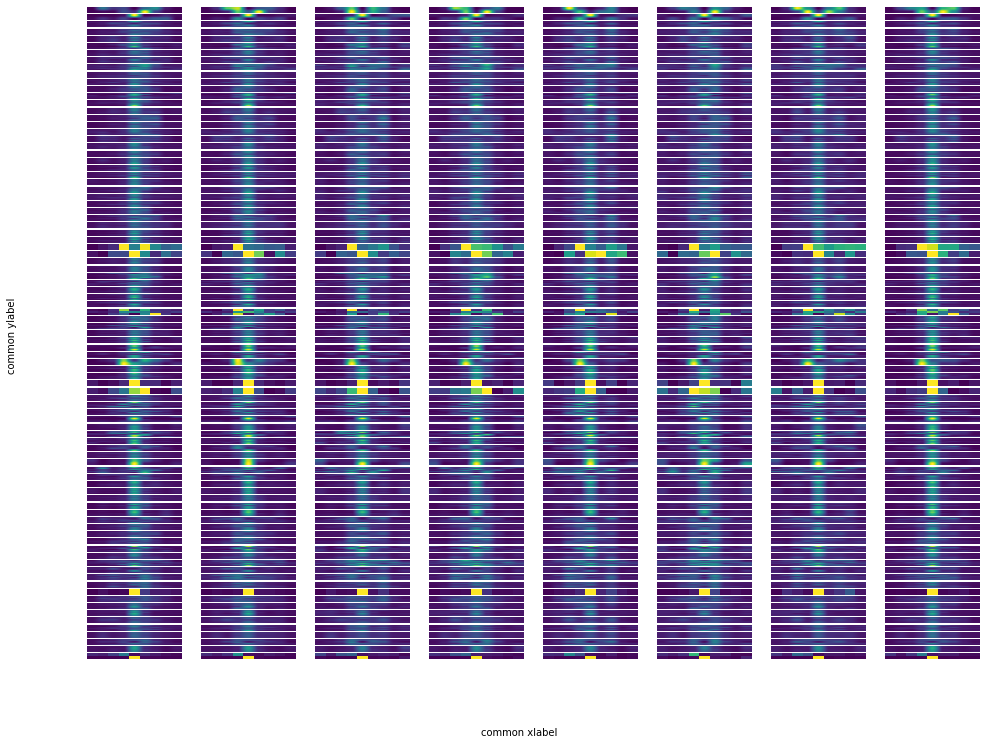

In [132]:
plt.rcParams["figure.figsize"] = (16, 12)
vis_filter(
    trainer = trainer_list[0],
    main = 'q',
    main_idxs = np.arange(0, 100, step = 1).tolist(), 
    head_idxs = np.arange(num_head).tolist(), 
    layer_idxs = [0], 
    x_axis = 'main', 
    y_axis = 'head',
    save_plot = False,
)

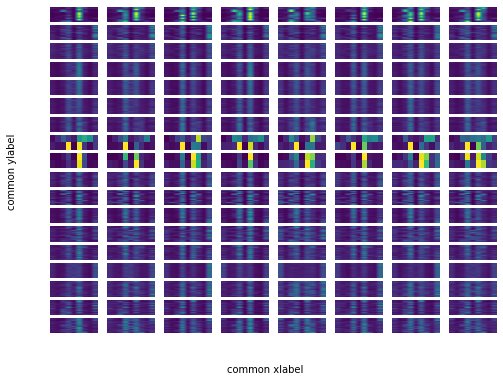

In [129]:
plt.rcParams["figure.figsize"] = (8, 6)
vis_filter(
    trainer = trainer_list[1],
    main = 'q',
    main_idxs = np.arange(0, 100, step = 5).tolist(), 
    head_idxs = np.arange(num_head).tolist(), 
    layer_idxs = [0], 
    x_axis = 'main', 
    y_axis = 'head',
    save_plot = False,
)

# visualization Figure 3 - (c)

In [111]:
get_idxs.keys()

dict_keys(['diff', 'head', 'layer'])

In [250]:
main_idxs_list

[[134, 42, 33, 8, 3, 2, 4, 1, 5, 13, 60, 50],
 [1, 5, 3, 2, 4, 11, 15, 14, 21, 108, 72, 124]]

In [263]:
if len(main_idxs_list[0]) != len(main_idxs_list[1]):
    main_idxs_list = [main_idxs[:min(len(main_idxs_list[0]), len(main_idxs_list[1]))] for main_idxs in main_idxs_list]

In [268]:
main_idxs_list

[[9, 15, 8, 1, 0, 6, 12, 5, 30, 18, 16],
 [10, 9, 13, 8, 1, 23, 32, 0, 6, 36, 14, 19]]

In [310]:
def is_valid_idx(q_idx):
    valid = True
    if str(skill_id_dict[q_idx]) == 'nan':
        valid = False
    if main_filter[q_idx][0] == []:
        valid = False
    return valid

In [337]:
a = skill_id_dict[main_idx] 
a = a + ' ' + a
a = a + ' ' + a
a = a + ' ' + a

a = re.sub(' ', '\n', a, count=0, flags=0)

In [338]:
a

'Proportion Proportion Proportion Proportion Proportion Proportion Proportion Proportion'

In [339]:
import re

In [340]:
a = re.sub(' ', '\n', a, count=0, flags=0)

In [341]:
a

'Proportion\nProportion\nProportion\nProportion\nProportion\nProportion\nProportion\nProportion'

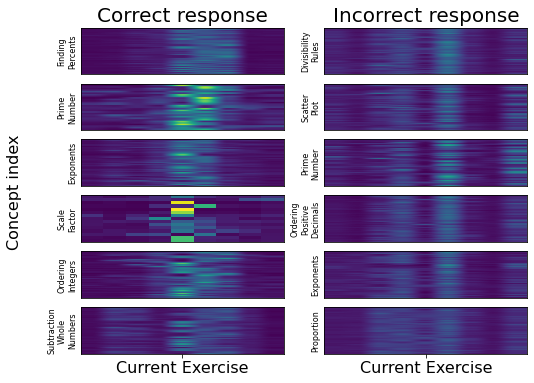

In [343]:
plt.rcParams["figure.figsize"] = (8, 6)

trainer = trainer_list

main = 'q'
# main_idxs_list = dist_q_list
# main_idxs_list = np.array([20, 40, 60, 80, 100]) - 10
main_idxs_list = [[9, 15, 8, 6, 12, 5, 30, 18, 16],
                  [10, 9, 13, 8, 1, 32, 0, 6, 36, 14, 19]]

head_idxs = np.arange(0, 1).tolist()
layer_idxs = [0]
x_axis = 'main'
y_axis = 'head'
save_plot = False

x_axis = main if x_axis is 'main' else x_axis
y_axis = main if y_axis is 'main' else y_axis

# check main column
assert main in ['q', 'pid', 'diff']

if len(main_idxs_list[0]) != len(main_idxs_list[1]):
    main_idxs_list = [main_idxs[1:min(len(main_idxs_list[0]), len(main_idxs_list[1]))+1] for main_idxs in main_idxs_list]

fig, axs = plt.subplots(len(main_idxs_list[0])-2, 2)

for trainer_idx, (trainer, main_idxs) in enumerate(zip(trainer_list, main_idxs_list)):
    fig_idx = 0
    
    # use only valid main idx
    main_filter = getattr(trainer, f'filter_dict_{main}')
    valid_filter_list = list(filter(is_valid_idx, main_filter.keys()))
    # valid_filter_list = list(filter(lambda x: main_filter[x][0] != [], main_filter.keys()))
    
    main_idxs = list(filter(lambda x: x in valid_filter_list, main_idxs))

    get_idxs = {
        f'{main}' : main_idxs,
        'head'  : head_idxs,
        'layer' : layer_idxs,
    }

    x_axis = main if x_axis is 'main' else x_axis
    y_axis = main if y_axis is 'main' else y_axis
    
    for main_plot_idx, main_idx in enumerate(main_idxs):
        for layer_plot_idxs, layer_idx in enumerate(layer_idxs):
            for head_plot_idxs, head_idx in enumerate(head_idxs):
                # get example filters per main
                filters = main_filter[main_idx]

                try:
                    filters[0][0].shape
                except:
                    pass

                # get example filters per layer, head
                filter_0_0 = torch.stack([filter_[head_idx] for filter_ in filters[layer_idx]], dim = 0)

                # plot
                plot_idxs = {
                    f'{main}'  : main_plot_idx,
                    'head'  : head_plot_idxs,
                    'layer' : layer_plot_idxs,
                }

                x_idx = plot_idxs[x_axis]
                y_idx = trainer_idx # y_idx = plot_idxs[y_axis]

                axs[x_idx, y_idx].imshow(filter_0_0.cpu().numpy(), interpolation='antialiased', aspect='auto')
                # axs[x_idx, y_idx].yaxis.set_visible(False)
                # axs[x_idx, y_idx].axis('off')
                
                # x_axis label
                if fig_idx == (axs.shape[0] - 1):
                    x_xticks = [4]
                    my_xticks = ['Current Exercise']

                    axs[x_idx, y_idx].set_xticks(x_xticks)
                    axs[x_idx, y_idx].set_xticklabels(my_xticks, fontsize = 16)

                else:
                    axs[x_idx, y_idx].set_xticks([])
                    axs[x_idx, y_idx].set_xticklabels('')
                
                
                
                # y_axis label
                skill_name = re.sub(' ', '\n', skill_id_dict[main_idx] , count=0, flags=0)
                
                axs[x_idx, y_idx].set_yticks([])
                axs[x_idx, y_idx].set_ylabel(f'{skill_name}', fontsize = 8, rotation=90)

                    
                if fig_idx == 0:
                    if trainer_idx == 0:
                        axs[x_idx, y_idx].set_title(f'Correct response', fontsize = 20)
                    else:
                        axs[x_idx, y_idx].set_title(f'Incorrect response', fontsize = 20)
                fig_idx += 1

# fig.text(0.5, 0.1, 'common xlabel', ha='center', va='center', fontsize = 20)
fig.text(0.01, 0.5, 'Concept index', ha='center', va='center', rotation='vertical', fontsize = 16)

# fig.suptitle('Correct Response', fontsize = 20)
# fig.suptitle('Incorrect Response', fontsize = 20)

# plt.show()
plt.savefig(f'../model_records/figure_3_c.pdf')

In [274]:
for main_idxs in main_idxs_list:
    for q_idx in main_idxs:
        print(skill_id_dict[q_idx])

Finding Percents
Prime Number
Exponents
Scale Factor
nan
Ordering Integers
Subtraction Whole Numbers
nan
Divisibility Rules
Scatter Plot
Prime Number
nan
Ordering Positive Decimals
nan
Exponents
Equivalent Fractions
Proportion


In [271]:
skill_id_dict = np.load('/root/BiDKT/datasets/assistments09/skill_id_name_2', allow_pickle='TRUE')
print(skill_id_dict)

{112: 'Circle Graph', 114: 'Circle Graph', 111: 'Circle Graph', 113: 'Circle Graph', 126: 'Median', 123: 'Range', 144: 'Table', 143: 'Table', 93: 'Multiplication and Division Integers', 75: 'Equation Solving Two or Fewer Steps', 74: 'Equation Solving More Than Two Steps', 94: 'Addition and Subtraction Positive Decimals', 6: 'Exponents', 47: 'Number Line', 59: 'Distributive Property', 96: 'Addition and Subtraction Integers', 102: 'Congruence', 28: 'Rounding', 21: 'Multiplication Fractions', 92: 'Addition and Subtraction Fractions', 26: 'Addition Whole Numbers', 29: 'Ordering Integers', 32: 'Ordering Positive Decimals', 77: 'Order of Operations +,-,/,* () positive reals', 49: 'Solving for a variable', 81: 'Surface Area Rectangular Prism', 71: 'Nets of 3D Figures', 39: 'Calculations with Similar Figures', 140: 'Table', 138: 'Table', 115: 'Probability of a Single Event', 141: 'Table', 142: 'Table', 37: 'Conversion of Fraction Decimals Percents', 19: 'Subtraction Whole Numbers', 27: 'Additi

# visualization Figure 3 - (b)

In [136]:
getattr(trainer, f'filter_dict_q').keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148])

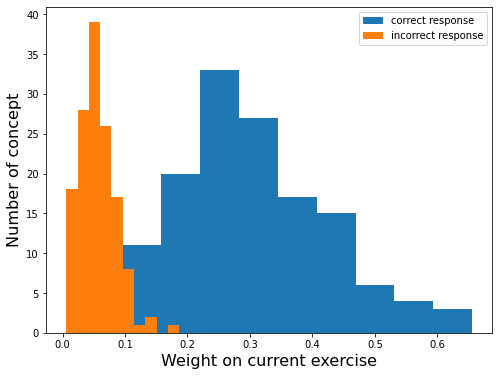

In [345]:
plt.rcParams["figure.figsize"] = (8, 6)
main = 'q'
# main = 'diff'

for trainer, correctness in zip(trainer_list, ['correct response', 'incorrect response']):
    # get valid filter list
    main_filter = getattr(trainer, f'filter_dict_{main}')
    valid_filter_list = list(filter(lambda x: main_filter[x][0] != [], main_filter.keys()))

    # get center weight w.r.t. filter
    center_weight = []
    num_samples = []
    for filter_idx in valid_filter_list:
        center_weight.append(float(torch.stack([filter_.mean(dim = 0) for filter_ in main_filter[filter_idx][0]]).mean(dim = 0)[4]))
        num_samples.append(len(main_filter[filter_idx][0]))
        
    hist_dict = {filter_idx : weight for filter_idx, weight in zip(valid_filter_list, center_weight)}
    plt.hist(center_weight, label = correctness)
        
plt.ylabel('Number of concept', fontsize = 16)
plt.xlabel('Weight on current exercise', fontsize = 16)
plt.legend()
plt.savefig(f'../model_records/figure_3_b.pdf')

In [258]:
# 범위에 맞는 q index 찾기
num_bins = 20
hist_list = []
for center_weight in center_weight_list:
    hist = np.histogram(center_weight, bins=num_bins, density=True)
    hist_list.append(hist)

In [259]:
dist_q_list = []
bins_idx_list = []

for center_weight, hist in zip(center_weight_list, hist_list):
    dist_q = []
    bins_idx_list_i = []
    for i in range(num_bins):
        bins_idx = (hist[1][i] < np.array(center_weight)) & (np.array(center_weight) < hist[1][i+1])
        bins_idx_list_i.append(bins_idx)
        # print(np.sum(min_ & max_))

        if len(np.array(center_weight)[bins_idx]) > 0:
            dist_q.append(center_weight.index(np.array(center_weight)[bins_idx][0]))
        else:
            pass
    dist_q_list.append(dist_q)
    bins_idx_list.append(bins_idx_list_i)

In [260]:
dist_q_list

[[2, 9, 15, 8, 1, 0, 6, 12, 5, 30, 18, 16],
 [3, 10, 9, 13, 8, 1, 23, 32, 0, 6, 36, 14, 19, 4]]

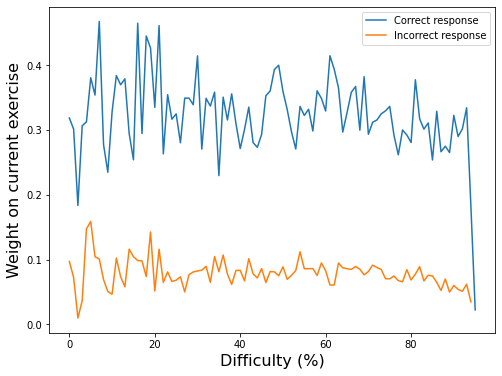

In [254]:
plt.rcParams["figure.figsize"] = (8, 6)
main = 'diff'

center_weight_list = []
for trainer, correctness in zip(trainer_list, ['Correct response', 'Incorrect response']):
    # get valid filter list
    main_filter = getattr(trainer, f'filter_dict_{main}')
    valid_filter_list = list(filter(lambda x: main_filter[x][0] != [], main_filter.keys()))

    # get center weight w.r.t. filter
    center_weight = []
    num_samples = []
    for filter_idx in valid_filter_list:
        center_weight.append(float(torch.stack([filter_.mean(dim = 0) for filter_ in main_filter[filter_idx][0]]).mean(dim = 0)[4]))
        num_samples.append(len(main_filter[filter_idx][0]))
    center_weight_list.append(center_weight)
    
    plt.plot(center_weight, label = correctness)
        
plt.ylabel('Weight on current exercise', fontsize = 16)
plt.xlabel('Difficulty (%)', fontsize = 16)
plt.legend()
plt.savefig(f'../model_records/figure_3_b.pdf')

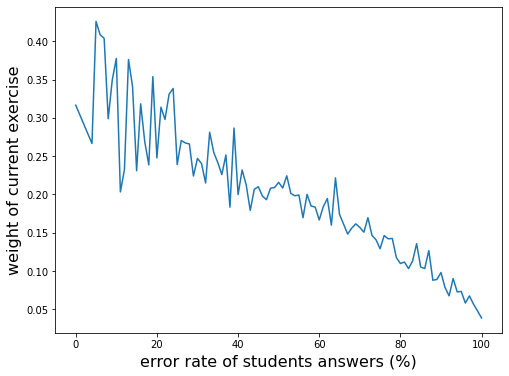

In [22]:
plt.plot(valid_filter_list, center_weight)
plt.ylabel('weight of current exercise', fontsize = 16)
plt.xlabel('Difficulty (%)', fontsize = 16)
plt.savefig(f'../model_records/figure_3_b.pdf')

In [81]:
main_filter = getattr(trainer, f'filter_dict_{main}')
valid_filter_list = list(filter(lambda x: len(main_filter[x][0]) > 0, main_filter.keys()))

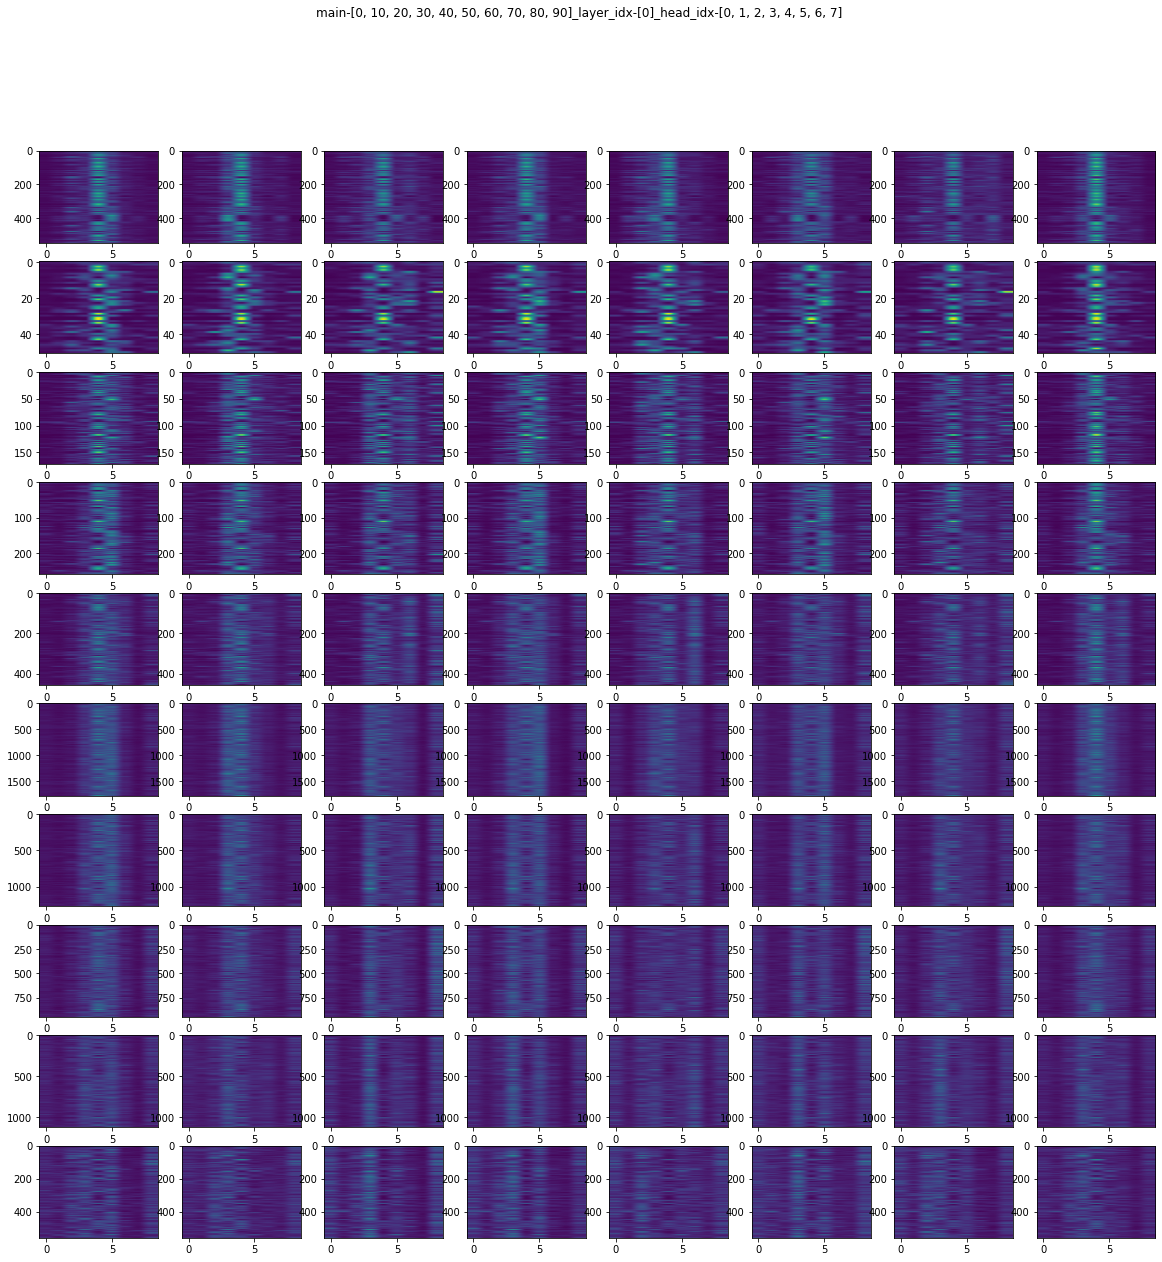

In [27]:
main = 'diff'
main_idxs = np.arange(0, 100, step = 1).tolist()
head_idxs = np.arange(0, num_head).tolist()
layer_idxs = [0]
x_axis = 'main'
y_axis = 'head'
save_plot = False



main_filter = getattr(trainer, f'filter_dict_{main}')
valid_filter_list = list(filter(lambda x: main_filter[x][0] != [], main_filter.keys()))

main_idxs = valid_filter_list

get_idxs = {
    f'{main}' : main_idxs,
    'head'  : head_idxs,
    'layer' : layer_idxs,
}

x_axis = main if x_axis is 'main' else x_axis
y_axis = main if y_axis is 'main' else y_axis

fig, axs = plt.subplots(len(get_idxs[x_axis]), len(get_idxs[y_axis]))

for main_plot_idx, main_idx in enumerate(main_idxs):
    for layer_plot_idxs, layer_idx in enumerate(layer_idxs):
        for head_plot_idxs, head_idx in enumerate(head_idxs):
            # get example filters per main
            filters = main_filter[main_idx]

            try:
                filters[0][0].shape
            except:
                pass

            # get example filters per layer, head
            filter_0_0 = torch.stack([filter_[head_idx] for filter_ in filters[layer_idx]], dim = 0)

            # plot
            plot_idxs = {
                f'{main}'  : main_plot_idx,
                'head'  : head_plot_idxs,
                'layer' : layer_plot_idxs,
            }

            x_idx = plot_idxs[x_axis]
            y_idx = plot_idxs[y_axis]

            axs[x_idx, y_idx].imshow(filter_0_0.cpu().numpy(), interpolation='antialiased', aspect='auto')

fig.suptitle(f'main-{main_idxs}_layer_idx-{layer_idxs}_head_idx-{head_idxs}')
plt.show()

In [106]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,30)
def vis_filter_diff(
    diff_idxs = [0, 25, 50, 75, 100], 
    head_idxs = np.arange(0, num_head).tolist(), 
    layer_idxs = [0], 
    x_axis = 'diff', 
    y_axis = 'head',
    save_plot = False,
):
    fig, axs = plt.subplots(len(get_idxs[x_axis]), len(get_idxs[y_axis]))

    for diff_plot_idx, diff_idx in enumerate(diff_idxs):
        for layer_plot_idxs, layer_idx in enumerate(layer_idxs):
            for head_plot_idxs, head_idx in enumerate(head_idxs):
                # get example filters per diff
                filters = trainer.filter_dict_diff[diff_idx]

                # get example filters per layer, head
                filter_0_0 = torch.stack([filter_[head_idx] for filter_ in filters[layer_idx]], dim = 0)

                # plot
                plot_idxs = {
                    'diff'  : diff_plot_idx,
                    'head'  : head_plot_idxs,
                    'layer' : layer_plot_idxs,
                }

                x_idx = plot_idxs[x_axis]
                y_idx = plot_idxs[y_axis]

                axs[x_idx, y_idx].imshow(filter_0_0.cpu().numpy(), interpolation='antialiased', aspect='auto')
                
    if save_plot:
        plt.savefig(f'diff-{diff_idx}_layer_idx-{layer_idx}_head_idx-{head_idx}.png')
    else:
        plt.show()

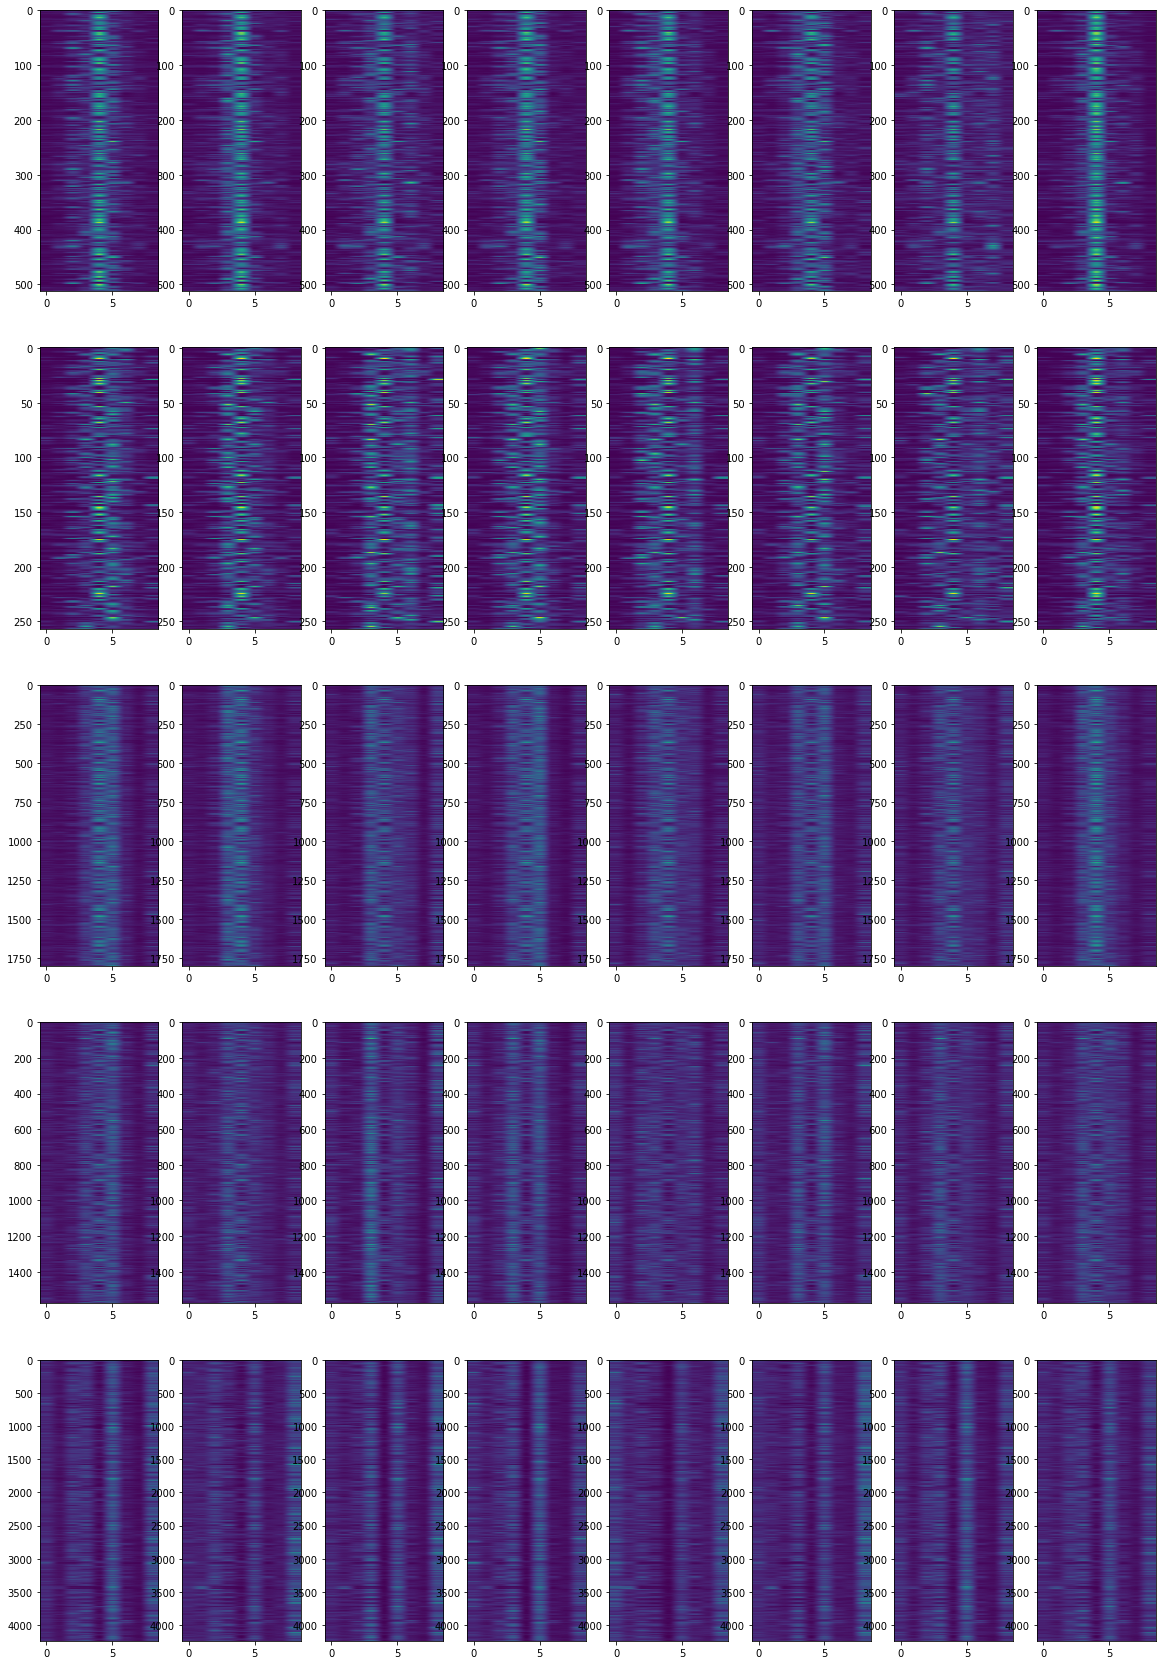

In [107]:
vis_filter_diff()

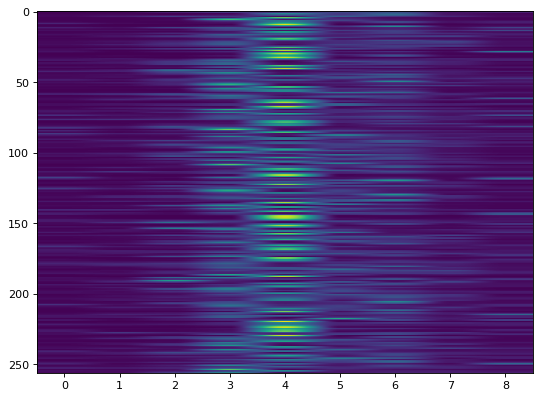

In [78]:
# get example filters per diff
diff_idx = 25
filters = trainer.filter_dict_diff[diff_idx]

# get example filters per layer, head
layer_idx = 0
head_idx = 7
filter_0_0 = torch.stack([filter_[head_idx] for filter_ in filters[layer_idx]], dim = 0)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(filter_0_0.cpu().numpy(), interpolation='antialiased', aspect='auto')
plt.savefig(f'diff-{diff_idx}_layer_idx-{layer_idx}_head_idx-{head_idx}.png')

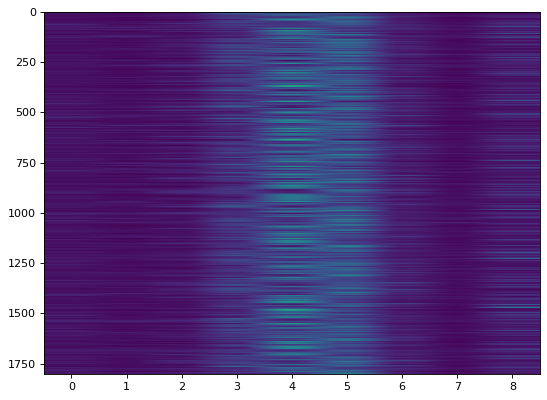

In [65]:
# get example filters per diff
diff_idx = 50
filters = trainer.filter_dict_diff[diff_idx]

# get example filters per layer, head
layer_idx = 0
head_idx = 0
filter_0_0 = torch.stack([filter_[head_idx] for filter_ in filters[layer_idx]], dim = 0)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(filter_0_0.cpu().numpy(), interpolation='antialiased', aspect='auto')
plt.savefig(f'diff-{diff_idx}_layer_idx-{layer_idx}_head_idx-{head_idx}.png')

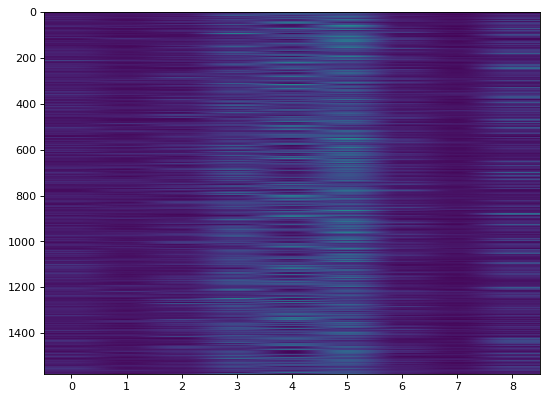

In [63]:
# get example filters per diff
diff_idx = 75
filters = trainer.filter_dict_diff[diff_idx]

# get example filters per layer, head
layer_idx = 0
head_idx = 0
filter_0_0 = torch.stack([filter_[head_idx] for filter_ in filters[layer_idx]], dim = 0)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(filter_0_0.cpu().numpy(), interpolation='antialiased', aspect='auto')
plt.savefig(f'diff-{diff_idx}_layer_idx-{layer_idx}_head_idx-{head_idx}.png')

In [25]:
# for 
[ filters[0][0][0] for ]
filters[0][0][0] # sample_idx, head_idx, kernel_size

tensor([0.0161, 0.0119, 0.0052, 0.0113, 0.8743, 0.0203, 0.0269, 0.0208, 0.0133],
       device='cuda:0')

In [97]:
model.encoder[0].attn.filters.shape

torch.Size([45600, 9, 1])

In [62]:
from einops import rearrange

In [105]:
for data in test_loader:
    break

In [179]:
%%time


CPU times: user 6.57 ms, sys: 883 µs, total: 7.46 ms
Wall time: 5.92 ms


In [177]:
q

'92'

In [178]:
filter_layers.shape

torch.Size([57, 100, 12, 8, 9])

IndexError: index 57 is out of bounds for dimension 0 with size 57

In [130]:
attn = model.encoder[encoder_idx].attn

In [132]:
rearrange(attn.filters, '(bs n h) k 1 -> bs n h k', n = max_seq_len, h = 8).shape

torch.Size([57, 100, 8, 9])

In [140]:
rearrange(attn.conv_value_vectors, 'bs (h_idx h_size) n 1 -> bs h_idx h_size n', h_idx = 8).shape

torch.Size([57, 8, 32, 100])

In [131]:
attn.conv_value_vectors.shape

torch.Size([57, 256, 100, 1])

In [ ]:
model.encoder[0].attn.attn_scores

In [ ]:
        filter_dict_q[]
        filter_dict_pid
        filter_dict_diff
        conv_value_dict_q
        conv_value_dict_pid
        conv_value_dict_diff

In [103]:
for encoder_idx, encoder in enumerate(model.encoder):
    

In [ ]:
filter_dict_q    = {f'{q_idx}' : {f'{layer_idx}' : [] for layer_idx in range(num_encoder)} for q_idx in range(model.num_q)}
filter_dict_pid  = {f'{emb_idx}' : {f'{layer_idx}' : [] for layer_idx in range(num_encoder)} for emb_idx in range(model.num_pid)}
filter_dict_diff = {f'{diff_idx}' : {f'{layer_idx}' : [] for layer_idx in range(num_encoder)} for diff_idx in range(model.num_diff)}

conv_value_dict_q    = {f'{q_idx}' : {f'{layer_idx}' : [] for layer_idx in range(num_encoder)} for q_idx in range(model.num_q)}
conv_value_dict_pid  = {f'{emb_idx}' : {f'{layer_idx}' : [] for layer_idx in range(num_encoder)} for emb_idx in range(model.num_pid)}
conv_value_dict_diff = {f'{diff_idx}' : {f'{layer_idx}' : [] for layer_idx in range(num_encoder)} for diff_idx in range(model.num_diff)}

In [104]:
encoder.attn.attn_scores.shape

torch.Size([57, 8, 100, 100])

In [98]:
model.encoder[0].attn.attn_scores.shape

torch.Size([57, 8, 100, 100])

In [102]:
model.encoder[0].attn.conv_value_vectors.squeeze().permute(0, 2, 1).shape

torch.Size([57, 100, 256])

In [100]:
filters = rearrange(model.encoder[0].attn.filters, '(bs n h) k 1 -> bs n h k', n = max_seq_len, h = 8).shape

torch.Size([57, 100, 8, 9])

In [43]:
rearrange(model.encoder[0].attn.filters, '(bs n h) k 1 -> bs n h k', n = max_seq_len, h = 8).shape

torch.Size([57, 100, 8, 9])

In [ ]:
model.encoder[0].attn.filters.shape

In [34]:
attn_outputs = attn_outputs.detach().cpu().numpy()
attn_probs = attn_probs.detach().cpu().numpy()
emb = emb.detach().cpu().numpy()
emb_q = emb_q.detach().cpu().numpy()
emb_pid = emb_pid.detach().cpu().numpy()
emb_diff = emb_diff.detach().cpu().numpy()

In [35]:
print("attn_outputs[0].size()", attn_outputs[0].size())
print("attn_probs[0][0].size()", attn_probs[0][0].size())
print("emb", emb.size())
print("emb_q", emb_q.size())
print("emb_pid", emb_pid.size())
print("emb_diff ", emb_diff.size())

TypeError: 'int' object is not callable

In [36]:
import pickle

attn_path = "../visual_records/attn_data.pkl"
outputs_path = "../visual_records/outputs.pkl"
emb_path = "../visual_records/emb.pkl"
emb_q_path = "../visual_records/emb_q.pkl"
emb_pid_path = "../visual_records/emb_pid.pkl"
emb_diff_path = "../visual_records/emb_diff.pkl"

# pickfile save
with open(attn_path, "wb") as f:
    pickle.dump(attn_probs, f)
with open(outputs_path, "wb") as f:
    pickle.dump(attn_outputs, f)
with open(emb_path, "wb") as f:
    pickle.dump(emb, f)
with open(emb_q_path, "wb") as f:
    pickle.dump(emb_q, f)
with open(emb_pid_path, "wb") as f:
    pickle.dump(emb_pid, f)
with open(emb_diff_path, "wb") as f:
    pickle.dump(emb_diff, f)

In [37]:
import pickle

attn_path = "../visual_records/attn_data.pkl"
outputs_path = "../visual_records/outputs.pkl"
emb_path = "../visual_records/emb.pkl"
emb_q_path = "../visual_records/emb_q.pkl"
emb_pid_path = "../visual_records/emb_pid.pkl"
emb_diff_path = "../visual_records/emb_diff.pkl"

# pickfile load
with open(attn_path, "rb") as f:
    attn_probs2 = pickle.load(f)
with open(outputs_path, "rb") as f:
    attn_outputs2 = pickle.load(f)
with open(emb_path, "rb") as f:
    emb2 = pickle.load(f)
with open(emb_q_path, "rb") as f:
    emb_q2 = pickle.load(f)
with open(emb_pid_path, "rb") as f:
    emb_pid2 = pickle.load(f)
with open(emb_diff_path, "rb") as f:
    emb_diff2 = pickle.load(f)

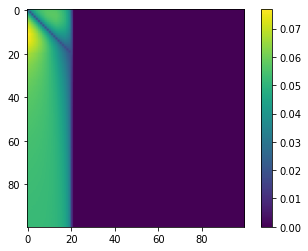

In [38]:
# 시각화

import matplotlib.pyplot as plt

score = attn_probs[0][0]

plt.viridis()
plt.imshow(score)
plt.colorbar()

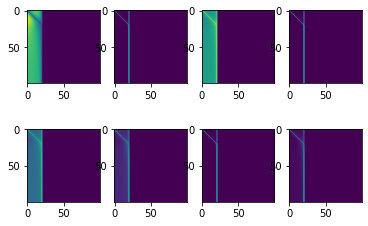

<Figure size 1440x576 with 0 Axes>

In [40]:
for i in range(8):
    score = attn_probs[0][i]
    plt.subplot(2,4,i+1)
    plt.viridis()
    plt.imshow(score)
    

plt.figure(figsize=(20, 8))
plt.show()


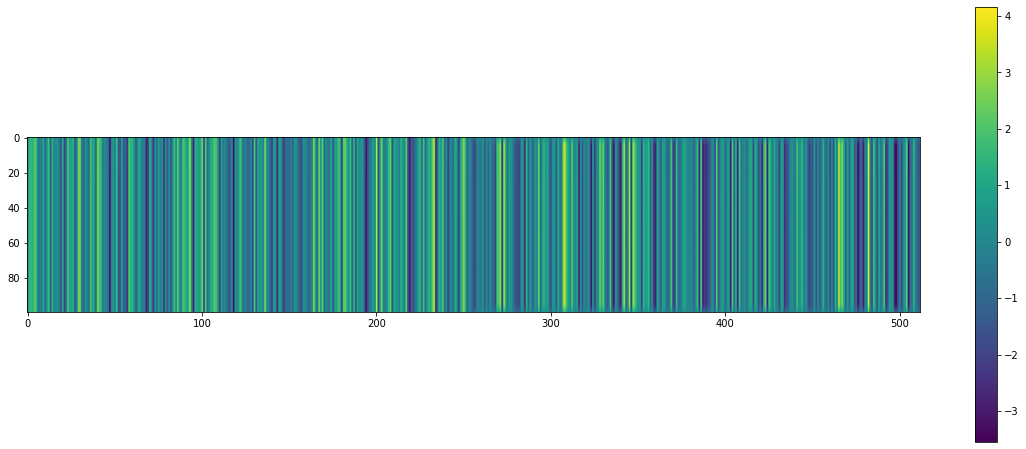

In [41]:
# 시각화

import matplotlib.pyplot as plt

outputs_score = attn_outputs[0]

plt.figure(figsize=(20, 8))
plt.viridis()
plt.imshow(outputs_score)
plt.colorbar()

In [42]:
#attn_probs2
#attn_outputs2
#emb2
#emb_q2
#emb_pid2
#emb_diff2

# t-sne
from sklearn.manifold import TSNE

# 2차원으로 차원 축소
n_components = 2

# t-sne 모델 생성
tsne_model = TSNE(n_components=n_components)

tsne_result = tsne_model.fit_transform(emb2)

print(tsne_result)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


ValueError: Found array with dim 3. Estimator expected <= 2.

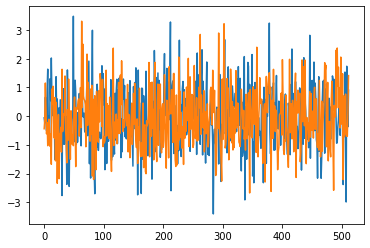

In [270]:
import matplotlib.pyplot as plt
# plt.imshow(model.emb_q.weight.detach().cpu().numpy()), print(model.emb_q.weight.detach().cpu().numpy().var())
plt.plot(model.emb_r.weight.t().detach().cpu().numpy()[:, 0])
plt.plot(model.emb_r.weight.t().detach().cpu().numpy()[:, 1])
# plt.imshow(model.emb_pid.weight.t().detach().cpu().numpy()[:, :1000]), print(model.emb_pid.weight.t().detach().cpu().numpy().var())
# plt.imshow(model.emb_diff.weight.detach().cpu().numpy()), print(model.emb_diff.weight.detach().cpu().numpy().var())
# plt.imshow(model.emb_p.weight.detach().cpu().numpy()), print(model.emb_p.weight.detach().cpu().numpy().var())
plt.show()

In [6]:
from torch.optim import Adam
from torch.nn.functional import binary_cross_entropy

optimizer = Adam(model.parameters(), learning_rate)
crit = binary_cross_entropy

In [6]:
from torch.optim import Adam
from torch.nn.functional import binary_cross_entropy

optimizer = Adam(model.parameters(), learning_rate)
crit = binary_cross_entropy

In [18]:
for idx, data in enumerate(tqdm(train_loader)):
    model.train()
    q_seqs, r_seqs, pid_seqs, diff_seqs, mask_seqs = data

    q_seqs = q_seqs.to(model.device) # |q_seqs| = (bs, n)
    r_seqs = r_seqs.to(model.device) # |r_seqs| = (bs, n)
    pid_seqs = pid_seqs.to(model.device) # |pid_seqs| = (bs, n)
    diff_seqs = diff_seqs.to(model.device)
    mask_seqs = mask_seqs.to(model.device) # |mask_seqs| = (bs, n)

    # for correct
    real_seqs = r_seqs.clone()

    # mlm_r_seqs: for MLM, [MASK] position get 2 / mlm_idx are index of [MASK]
    mlm_r_seqs, mlm_idxs = Mlm4BertTrain(r_seqs, mask_seqs)
    mlm_r_seqs = mlm_r_seqs.to(model.device)
    mlm_idxs = mlm_idxs.to(model.device)
    break    

  0%|          | 0/61 [00:00<?, ?it/s]


In [64]:
# model input
q = q_seqs.long()
r = r_seqs.long()
pid = pid_seqs.long()
diff = diff_seqs.long()
mask = mask_seqs.long()

In [65]:
model.eval()

# generate encoder input
emb = model.emb_q(q) + model.emb_r(r) + model.emb_pid(pid) + model.emb_diff(diff) + model._positional_embedding(q)
# |emb| = (bs, n, emb_size)

z = model.emb_dropout(emb)
# |z| = (bs, n, emb_size)

# |mask_enc| = (bs, n, n)
# |z| = (bs, n, emb_size)
attn_probs = None
attn_outputs = None

In [66]:
x = z
for enc_idx, block in enumerate(model.encoder):
    break

In [67]:
# z = x + model.encoder[enc_idx].attn_dropout(
#     model.encoder[enc_idx].attn(Q=z, K=z, V=z, mask=mask)
# )

z = model.encoder[enc_idx].attn_norm(x)

# encoder input
Q=z 
K=z
V=z
mask=mask

In [ ]:
# z = z + model.encoder[enc_idx].fc_dropout(model.encoder[enc_idx].fc(model.encoder[enc_idx].fc_norm(z)))

In [76]:
## MHSA qkv
batch_size = Q.size(0)

mixed_query_layer = model.encoder[enc_idx].attn.query(Q)
mixed_key_layer = model.encoder[enc_idx].attn.key(K)
mixed_value_layer = model.encoder[enc_idx].attn.value(V)

query_layer = model.encoder[enc_idx].attn.transpose_for_scores(mixed_query_layer)
# |query_layer| = (bs, n_attn_head, n, attn_head_size) = (64, 8, 100, 32)
key_layer = model.encoder[enc_idx].attn.transpose_for_scores(mixed_key_layer)
# |query_layer| = (bs, n_attn_head, n, attn_head_size) = (64, 8, 100, 32)
value_layer = model.encoder[enc_idx].attn.transpose_for_scores(mixed_value_layer)
# |query_layer| = (bs, n_attn_head, n, attn_head_size) = (64, 8, 100, 32)

In [77]:
## conv qkv
mixed_key_conv_attn_layer = model.encoder[enc_idx].attn.key_conv_attn_layer(
    K.transpose(1, 2) # |hidden_states.transpose(1, 2)| = (bs, hs, n)
)
# |mixed_key_conv_attn_layer| = (bs, hs/2(all_attn_h_size), n)
mixed_key_conv_attn_layer = mixed_key_conv_attn_layer.transpose(1, 2)
# |mixed_key_conv_attn_layer| = (bs, n, hs/2(all_attn_h_size))

In [210]:
##############
# conv layer #
##############
# element-wise multiply of conv key and query 
conv_attn_layer = torch.multiply(mixed_key_conv_attn_layer, mixed_query_layer)

In [216]:
# |conv_attn_layer| = (bs, n, hs/2(all_attn_h_size))
conv_kernel_layer = model.encoder[enc_idx].attn.conv_kernel_layer(conv_attn_layer)

In [217]:
conv_kernel_layer.shape

torch.Size([64, 100, 72])

In [212]:
# |conv_kernel_layer| = (bs, n, (n_attn_h * conv_kernel_size) = (64, 100, 8 * 9) = (64, 100, 72)
conv_kernel_layer = torch.reshape(conv_kernel_layer, [-1, model.encoder[enc_idx].attn.conv_kernel_size, 1])

In [213]:
# |conv_kernel_layer| = (51200, 9, 1)
conv_kernel_layer = torch.softmax(conv_kernel_layer, dim=1)
# |conv_kernel_layer| = (51200, 9, 1)

In [218]:
# q X k is matmul with v
conv_out_layer = model.encoder[enc_idx].attn.conv_out_layer(V)

In [219]:
conv_out_layer.shape

torch.Size([64, 100, 256])

In [196]:
# |conv_out_layer| = (bs, n, hs/2(all_attn_h_size))
conv_out_layer = torch.reshape(conv_out_layer, [batch_size, -1, model.encoder[enc_idx].attn.all_head_size])

In [197]:
# |conv_out_layer| = (bs, n, hs/2(all_attn_h_size))
conv_out_layer = conv_out_layer.transpose(1, 2).contiguous().unsqueeze(-1)
# |conv_out_layer| = (bs, hs/2(all_attn_h_size), n, 1)

In [198]:
# unfold 참고 -> #https://www.facebook.com/groups/PyTorchKR/posts/1685133764959631/
conv_out_layer = nn.functional.unfold( 
    conv_out_layer,
    kernel_size=[model.encoder[enc_idx].attn.conv_kernel_size, 1],
    dilation=1,
    padding=[(model.encoder[enc_idx].attn.conv_kernel_size - 1) // 2, 0],
    stride=1,
)

In [199]:
# |conv_out_layer| = (64, 2304, 100)
conv_out_layer = conv_out_layer.transpose(1, 2).reshape(
    batch_size, -1, model.encoder[enc_idx].attn.all_head_size, model.encoder[enc_idx].attn.conv_kernel_size
)

In [200]:
# |conv_out_layer| = (bs, n, hs/2(all_attn_h_size), conv_kernal_size)
conv_out_layer = torch.reshape(conv_out_layer, [-1, model.encoder[enc_idx].attn.attention_head_size, model.encoder[enc_idx].attn.conv_kernel_size])
# |conv_out_layer|, default = (51200, 32, 9)

In [201]:
conv_out_layer.shape

torch.Size([51200, 32, 9])

In [202]:
conv_kernel_layer.shape

torch.Size([51200, 9, 1])

In [203]:
# matmul(q X k, v)
conv_out_layer = torch.matmul(conv_out_layer, conv_kernel_layer)
# |conv_out_layer|, default = (51200, 32, 1)

In [206]:
from einops import rearrange

In [208]:
conv_out_layer_einsum = torch.einsum('s h k, s k i -> s h i', conv_out_layer, conv_kernel_layer)

In [209]:
conv_out_layer_einsum.shape

torch.Size([51200, 32, 1])

In [ ]:
conv_out_layer = torch.reshape(conv_out_layer, [-1, model.encoder[enc_idx].attn.all_head_size])
# |conv_out_layer|, default = (6400, 256)

In [72]:
###################
# self_attn layer #
###################
attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
# |attention_scores| = (bs, n_attn_head, n, n), default = (64, 8, 100, 100)
attention_scores = attention_scores / math.sqrt(model.encoder[enc_idx].attn.attention_head_size)
# |attention_scores| = (bs, n_attn_head, n, n), default = (64, 8, 100, 100)

#####################
# distance function #
#####################
dist_scores = model.encoder[enc_idx].attn.dist_func(attention_scores, mask)
# |dist_scores| = (bs, n_attn_head, n, n), default = (64, 8, 100, 100)
m = nn.Softplus()
# gamma is learnable decay rate parameter
gamma = -1.0 * m(model.encoder[enc_idx].attn.gammas).unsqueeze(0)
# Now after do exp(gamma * distance) and then clamp to 1e-5 to 1e-5
total_effect = torch.clamp(
    torch.clamp((dist_scores * gamma).exp(), min=1e-5), max=1e5
)
# |total_effect| = (bs, n_attn_head, n, n), default = (64, 8, 100, 100)

attention_scores = attention_scores * total_effect
# |attention_scores| = (bs, n_attn_head, n, n), default = (64, 8, 100, 100)

# |mask| = (bs, n)
attention_mask = model.encoder[enc_idx].attn.get_extended_attention_mask(mask)
# |attention_mask| = (bs, n_attn_head, n, n), default = (64, 8, 100, 100)
attention_scores = attention_scores.masked_fill_(attention_mask==0, -1e8)
# |attention_scores| = (bs, n_attn_head, n, n) = (64, 8, 100, 100)

attention_probs = nn.functional.softmax(attention_scores, dim=-1)
# |attention_probs| = (bs, n_attn_head, n, n) = (64, 8, 100, 100)
attention_probs = model.encoder[enc_idx].attn.dropout(attention_probs)
# |attention_probs| = (bs, n_attn_head, n, n) = (64, 8, 100, 100)

context_layer = torch.matmul(attention_probs, value_layer)
# |context_layer| = (bs, n_attn_head, n, attn_head_size) = (64, 8, 100, 32)
context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
# |context_layer| = (bs, n, n_attn_head, attn_head_size) = (64, 100, 8, 32)

#########################################
# concat with conv and self_attn values #
#########################################
conv_out = torch.reshape(conv_out_layer, [batch_size, -1, model.encoder[enc_idx].attn.num_attention_heads, model.encoder[enc_idx].attn.attention_head_size])
# |conv_out| = (bs, n, n_attn_head, attn_head_size) = (64, 100, 8, 32)
context_layer = torch.cat([context_layer, conv_out], 2)
# |context_layer| = (bs, n, n_attn_head * 2, attn_head_size) = (64, 100, 16, 32)
new_context_layer_shape = context_layer.size()[:-2] + \
     (model.encoder[enc_idx].attn.head_ratio * model.encoder[enc_idx].attn.all_head_size,)
# new_context_layer_shape = (bs, n, hs)
context_layer = context_layer.view(*new_context_layer_shape)
# |context_layer| = (bs, n, hs)

outputs = context_layer
# |context_layer| = (bs, n, hs)
# if you need attention_probs, add the return
# |attention_probs| = (bs, n_attn_head, n, n) = (64, 8, 100, 100)

# |outputs| = (bs, n, hs)